In [1]:
import numpy as np
#import scipy
from scipy import integrate, LowLevelCallable
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
import os, ctypes


In [2]:
# Kinetic correlations and parameters
# Billimoria 1981, Weng 1975 and Price 1977, the hydrogenation of Benzene example!!
prams = {'k0': 3.17e-2,                 # kmol/kgsPa
        'K0': 3.17e-13,                 # 1/Pa
        'E' : 5.76e7,                   # J/kmol
        'Q': 6.89e7,                    # J/kmol (-) sign
        'kd0': 1.80e-4,                 # 1/Pa/s
        'Ed': 4.53e6,                   # J/kmol
        'R': 8.3145,                    # J/mol/K
        'MT': 4.05e-4,                  # kg/kmol (from Weng, 1.03e-3, mol/kg_catalyst)
        'DeB': 4.5e-5,                  # m2/s
        'rho_Cp': 1.46e-6,              # J/m3/oC
        'eps': 0.58,
        'rho_B': 4.14e-2,               # kg/m3
        'dH': 2.09e8,                   #J/kmol               
        }                 


In [3]:
# ccalculation of <rho*Cp>
# <rho*Cp> = rho*Cp (catalyst + diluent) + rho*Cp (reactor wall + thermo_well) + rho_g*eps*Cp_g
# rho*Cp (catalyst + diluent) = [W_T*Cp_c + (1-W_T)*Cp_d]*rho_B

In [4]:
def lambda_e(LeH,rho_g,Cp_g,U,dp):
    return 5.1*LeH+0.8*rho_g*Cp_g*U*dp

In [5]:
def cp_g(xH,xB):
    return (2.902*xH + 96.86*xB)*10^4

In [6]:
def mw_g(xH,xB):
    return 2.106*xH + 78.12*xB

In [7]:
def rho_g_m1(cB,xB,xH):
    return cB*MW_g(xB,xH)/xB

In [8]:
def rho_g_m2(MW_g,P,T0):
    return MW_g*273.16*P/(22.161 + 1.0132e5*T0)

In [9]:
def cp_H(T):
    return 2.9199e4 + 2.0515*(T-400)-1.256e-2*(T-499)^2

In [10]:
def cp_B(T):
    return 1.1196e5 + 2.7528e2*(T-400)-2.1562e-1*(T-400)^2

In [11]:
dT_ad = lambda xB0,dH,MW_g,Cp_g: xB0*(-dH)/(MW_g*Cp_g)
#dT_ad(0.5,120,65,4.14)


In [12]:
# Catalyst effectiveness parameters
pramc = {'Blh': 1,           # no units
         'Blm': 6.5,         # no units, assuming j_d = j_h
         'h': 2.2e2,         # J/m2/s/oC
         'km': 4.1e-2,       # m/s
         'rB': 0.162,        # kmol/m3/s (= k1*cB), assuming kinetics of first order
         'kl': 7.6e-2,       # m3/kg/s
         'rho_c': 4.3e3,     # kg/m3
         'Dc': 5.2e-6,       # m2/s
         'Lc': 0.15,         # J/m/s/oC
         'phi': 2.2,         # no units, r_p/(kl*rho_c/Dc)^(1/3),(2.2 for 12 mesh and 1.1 for 20 mesh)
         'gma': 3.3,         # no units, E/RT = 2700/(1.98*413)
         'bta': 8.56e-3      # no units, cB_0*(-dH)*Dc/(Lc*T_B) 
        }

In [13]:
def r_B(P,xB,xH,T,prams):
    k0 = prams['k0']                 
    K0 = prams['K0']                 
    E =  prams['E']                 
    Q =  prams['Q']
    R =  prams['R']
    r = (k0*K0*np.exp((Q-E)/(R*T))*P**2*xB*xH)/(1 + K0*np.exp(Q/(R*T))*P*xB)
    return r

def r_D(P,xT,T,s,prams):
    kd0 = prams['k0']   
    Ed =  prams['Ed']                 
    R =  prams['R']   
    r = (kd0*np.exp((-Ed)/(R*T))*P**xT*s)
    return r

In [14]:
params = {'D':0.01,'U':0.005,'k':0.055,'Le':0.0024,'DeltaH':2.062e10}

In [15]:
def R(c,k):
    r = k*c
    return r

In [16]:
def H(DeltaH,r):
    Q = DeltaH*r
    return Q

In [17]:
def mass_energy_bal(y, t,D,U,k,Le,DeltaH):
    # Define concentrations and Temps according to the output y
    c = y[::2]
    T = y[1::2]
    dx = c[1]-c[0]

    # initialize the output derivatives
    dydt = np.empty_like(y)

    # from the interleaved output derivatives slice out dcdt and dTdt
    # vectors in dydt.
    dcdt = dydt[::2]
    dTdt = dydt[1::2]

    # Compute dc/dt and dT/dt considering the boundaries (end points) and the interior points
    dcdt[0]    = D * (-2.0*c[0] + 2.0*c[1]) / dx**2 + R(c[0], k) + U*0
    dcdt[1:-1] = D * (c[:-2]-2.0*c[1:-1] + c[2:]) / dx**2 + U *(c[2:] - c[:-2])/(2*dx) + R(c[1:-1], k)
    dcdt[-1]   = D * (- 2.0*c[-1] + 2.0*c[-2]) / dx**2 + U *(c[-1]-c[-2])/(2*dx) + R(c[-1],k)
    
    dTdt[0]    = Le * (-2.0*T[0] + 2.0*T[1]) / dx**2 + H(DeltaH,R(c[0], k)) + U*0 
    dTdt[1:-1] = Le * (T[:-2]-2.0*T[1:-1] + T[2:]) / dx**2 + U *(T[2:] - T[:-2])/(2*dx) + H(DeltaH,R(c[1:-1], k))
    dTdt[-1]   = Le * (-2.0*T[-1] + 2.0*T[-2]) / dx**2 + U *(T[-1]-T[-2])/(2*dx) + H(DeltaH,R(c[-1],k))
    return dydt

# v[1:-1] = (u[2:] - u[:-2])/(2*dt)

In [18]:
#     dcdt[0]    = D * (-2.0*c[0] + 2.0*c[1]) / dx**2 + R(c[0], k) + U*0
#     dcdt[1:-1] = D * np.diff(c,2) / dx**2 + R(c[1:-1], k) + U
#     dcdt[-1]   = D * (- 2.0*c[-1] + 2.0*c[-2]) / dx**2 + U*0 + R(c[-1],k)
    
#     dTdt[0]    = Le * (-2.0*T[0] + 2.0*T[1]) / dx**2 + H(DeltaH,R(c[0], k)) + U*0 
#     dTdt[1:-1] = Le * np.diff(T,2) / dx**2 + U + H(DeltaH,R(c[1:-1], k))
#     dTdt[-1]   = Le * (-2.0*T[-1] + 2.0*T[-2]) / dx**2 + U*0 + H(DeltaH,R(c[-1],k))

In [19]:
# dcdt[0]    = D * (-2.0*c[0] + 2.0*c[1]) / dx**2 + R(c[0], k) + U*(c[0]-c[0])/(dx) 
# dcdt[1:-1] = D * np.diff(c,2) / dx**2 + R(c[1:-1], k) + U*np.diff(c,1)/(dx) 
# dcdt[-1]   = D * (- 2.0*c[-1] + 2.0*c[-2]) / dx**2 + U*(c[-2]-c[-2])/(dx) + R(c[-1],k)
    
# dTdt[0]    = Le * (-2.0*T[0] + 2.0*T[1]) / dx**2 + U*(T[0]-T[0])/(dx)+ H(DeltaH,R(c[0], k)) 
# dTdt[1:-1] = Le * np.diff(T,2) / dx**2 + U*np.diff(T)/(dx) + H(DeltaH,R(c[1:-1], k))
# dTdt[-1]   = Le * (-2.0*T[-1] + 2.0*T[-2]) / dx**2 + U*(T[-2]-T[-2])/(dx)+ H(DeltaH,R(c[-1],k))


In [20]:
y0 = np.array([0.5,1,170,180,0.2,160])
t = np.linspace(0, 50, 101)
D = params['D']
U = params['U']
k = params['k']
Le = params['Le']
DeltaH = params['DeltaH']

In [21]:
n = t.size
#print(n)
t[0:n-1],t[0:-1]


(array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
        27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
        33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
        38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
        44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
        49.5]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23

In [22]:
solb = odeint(mass_energy_bal, y0, t, args= (D, U, k, Le, DeltaH), ml=2, mu=2)
solb.shape

(101, 6)

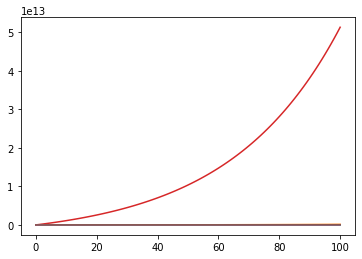

In [23]:
plt.figure()
plt.plot(solb)
plt.show()

In [24]:
def mass_energy_bal2(t,y):
    
    Params = {'D':0.4e-4,'U':0.01,'k':0.055,
              'Le':1.58,'DeltaH':2.062e8}
    
    D = params['D']
    U = params['U']
    k = params['k']
    Le = params['Le']
    DeltaH = params['DeltaH']
       
    c = y[::2]
    T = y[1::2]
    dx = c[1]-c[0]

    # initialize the output derivatives
    dydt = np.empty_like(y)

    # slice out concentrations and Temps derivatives.
    dcdt = dydt[::2]
    dTdt = dydt[1::2]

    # Compute dc/dt and dT/dt considering the boundaries (end points) and the interior points
    
    dcdt[0]    = D * (-2.0*c[0] + 2.0*c[1]) / dx**2 + R(c[0], k) + U
    dcdt[1:-1] = D * np.diff(c,2) / dx**2 + R(c[1:-1], k) + U
    dcdt[-1]   = D * (- 2.0*c[-1] + 2.0*c[-2]) / dx**2 + U + R(c[-1],k)
    
    dTdt[0]    = Le * (-2.0*T[0] + 2.0*T[1]) / dx**2 + H(DeltaH,R(c[0], k)) + U 
    dTdt[1:-1] = Le * np.diff(T,2) / dx**2 + U + H(DeltaH,R(c[1:-1], k))
    dTdt[-1]   = Le * (-2.0*T[-1] + 2.0*T[-2]) / dx**2 + U + H(DeltaH,R(c[-1],k))

    return dydt

In [25]:
solc = solve_ivp(mass_energy_bal2,t,y0, method='RK45',dense_output=True)

In [26]:
# solc

In [27]:
solc.y[0].shape

(11,)

In [28]:
x_solc1 = solc.sol(t).T

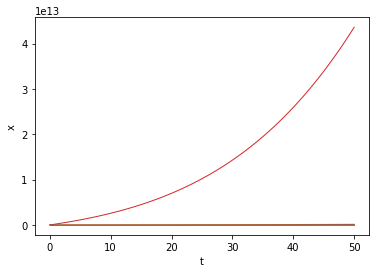

In [29]:
plt.figure()
plt.plot(t, x_solc1, linewidth=1)
plt.xlabel('t')
plt.ylabel('x')
plt.show()

In [30]:
# Example 
#v(n) = u(n+1)-u(n-1)/2*dt
#u'(0), v(0) = 0
#n(n) = u(n)-u(n-1)/dt
T = 100
dt = 0.025
Nt = int(round(T/dt))
u = np.zeros(Nt+1)
t = np.linspace(0, Nt*dt, Nt+1)

In [31]:
v = np.zeros_like(u) # or v = np.zeros(len(u))
# Use central difference for internal points
for i in range(1, len(u)-1):
    v[i] = (u[i+1] - u[i-1])/(2*dt)
# Use initial condition for u’(0) when i=0
v[0] = 0
# Use backward difference at the final mesh point
v[-1] = (u[-1] - u[-2])/dt

In [32]:
v = np.zeros_like(u)
v[1:-1] = (u[2:] - u[:-2])/(2*dt) # central difference
v[0] = 0 # boundary condition u’(0)
v[-1] = (u[-1] - u[-2])/dt # backward difference

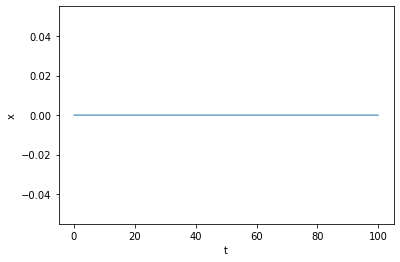

In [33]:
plt.figure()
plt.plot(t, v, linewidth=1)
plt.xlabel('t')
plt.ylabel('x')
plt.show()